In [1]:
from automl_surrogate.data.heterogeneous.dataset import HeteroPipelineDataset
from automl_surrogate.models.heterogeneous.listwise.pipelines_ranking import HeteroPipelineRankingSurrogateModel
import yaml

/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
with open ("/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/id2pipeline_path.pickle", "rb") as f:
    id2pipe = pickle.load(f)
with open ("/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/id2dataset_id.pickle", "rb") as f:
    id2dataset = pickle.load(f)

ds = HeteroPipelineDataset(
    "/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/train_task_pipe_comb.csv",
    id2pipe,
    id2dataset,
    pipelines_per_step=30,
    use_dataset_with_id=27,
)

/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_squared link alias is deprecated. Use InverseSquared instead. The

In [3]:
with open("/home/cherniak/itmo_job/surrogate/configs/mhsa_ranking_surrogate.yml") as f:
    config = yaml.safe_load(f)
model_config = {k: v for k, v in config["model"].items() if k != "class"}

In [4]:
import torch
model = HeteroPipelineRankingSurrogateModel(**model_config)
state_dict = torch.load(
    "/home/cherniak/itmo_job/surrogate/experiment_logs/no_meta_features_and_fedot_pipelines_(type_and_hparams)/train_node_embedder_from_scratch/overfit_27th_dataset/simple_graph_encoder/rank_over_10/mhsa/version_0/checkpoints/last.ckpt",
    map_location="cpu",
)["state_dict"]
model.load_state_dict(state_dict)
model = model.eval()

In [5]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, init='pca')

In [6]:
samples_ = [ds[i] for i in range(128)]

In [7]:
# import pickle
# with open("samples.pickle", "wb") as f:
#     pickle.dump(samples_, f)

In [45]:
from copy import deepcopy
samples = deepcopy(samples_)

In [46]:
# import torch
# for (s, _) in samples:
#     for p in s:
#         min_edge_id = p.edge_index.min().item()
#         max_edge_id = p.edge_index.max().item()
#         shape = p.edge_index.shape
#         p.edge_index = torch.randint(min_edge_id, max_edge_id, shape)

In [47]:
batch = ds.collate_fn(samples)
x, y = batch

In [48]:
# import torch
# for i in range(len(x)):
#     for k, v in x[i].hparams.items():
#         x[i].hparams[k] = torch.rand_like(v)

In [49]:
import torch
import numpy as np

for i in range(len(x)):
    for k, v in x[i].encoded_type.items():
        x[i].encoded_type[k] = torch.full_like(v, np.random.randint(0, 99))

In [50]:
with torch.no_grad():
    pipeline_embs_ = model.encode_pipelines(x)

    mhsa_output = model.mhsa_block(pipeline_embs_)
    scores = model.linear(mhsa_output).squeeze(2)

In [51]:
pipeline_embs = []
for e in pipeline_embs_:
    pipeline_embs.extend([t.numpy() for t in e])

y_flat = []
for e in y:
    y_flat.extend(e)

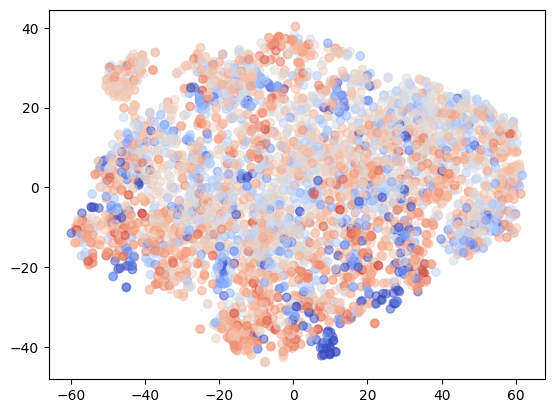

In [52]:
import matplotlib.pyplot as plt
import numpy as np

pipeline_embs = np.stack(pipeline_embs)
transformed = tsne.fit_transform(pipeline_embs)
plt.scatter(*transformed.T, c=y_flat, cmap="coolwarm", alpha=0.5)

In [53]:
from scipy.stats import kendalltau
from sklearn.metrics import ndcg_score
from automl_surrogate.metrics import precision

kts = []
ndscgs = []

for a, b in zip(y, scores):
    kts.append(kendalltau(a, b)[0])
    ndscgs.append(ndcg_score(a.reshape(1, -1), b.reshape(1, -1)))

In [54]:
import numpy as np
np.mean(ndscgs), np.mean(kts), precision(y, scores)

(0.9606084646132261, 0.2490481233358894, 0.05859375)